## Medical image data - BoneMRI


In [1]:
# Library imports
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pydicom
import os
import cv2
import napari

from image_utils import *

data_path = os.path.join("boneMRI", "20240119_BoneMRI_EBS23")
segmentation_path = os.path.join("boneMRI", "20240119_BoneMRI_EBS23_Segmentations.nii")

## Loading the data

The shape of the image is (100, 672, 672)


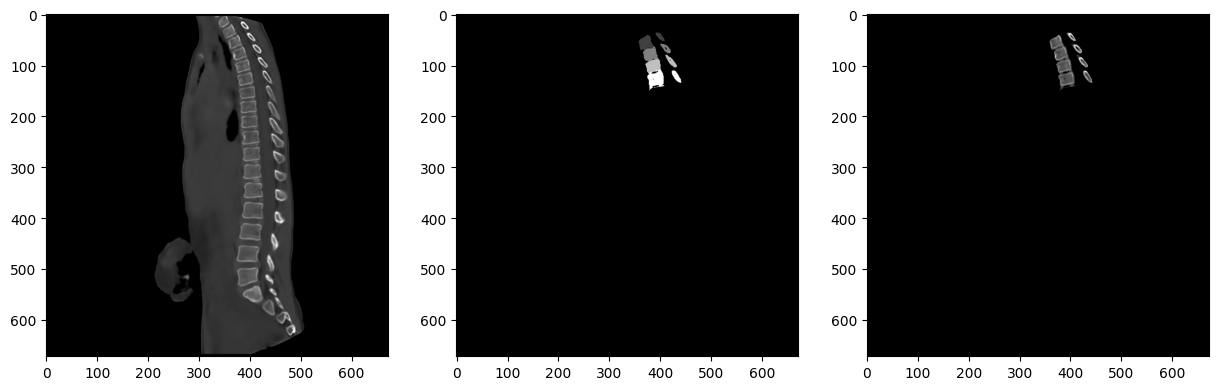

In [2]:
# Load segmentation data
segment = nib.load(segmentation_path)
segment_data = np.transpose(segment.get_fdata())
segment_header = segment.header
segment_all = segment_data > 0

# Load dicom data and apply windowing
dicom_image = load_3d_dicom(data_path)
dicom_image = apply_window(dicom_image, window_level=450, window_width=1500)
segment_dicom_image = dicom_image*segment_all
print(f"The shape of the image is {dicom_image.shape}")

# Plot data 
slice_index = 50  # Middle slice along the z-axis
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(dicom_image[slice_index, :, :], cmap='gray')
ax[1].imshow(segment_data[slice_index, :, :], cmap='gray')
ax[2].imshow(segment_dicom_image[slice_index, :, :], cmap='gray');

## Image compression to 2D

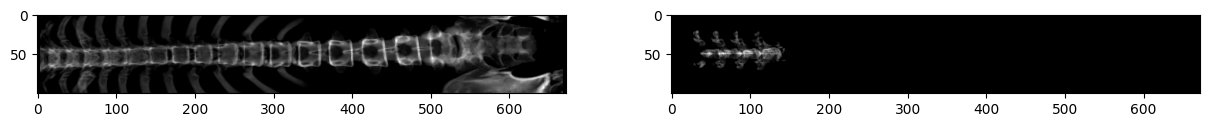

In [3]:
# Compress image
compressed_dicom_image = compress_bonemri(dicom_image, axis=2)
compressed_segment_dicom_image = compress_bonemri(segment_dicom_image, axis=2)

# Plot data
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(compressed_dicom_image, cmap='gray')
ax[1].imshow(compressed_segment_dicom_image, cmap='gray');

## Image rotation

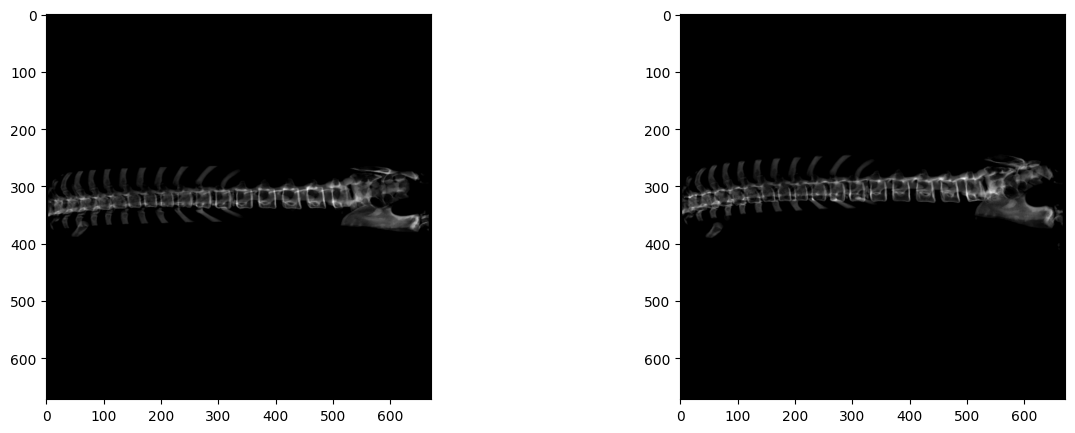

In [4]:
# Rotate full images
rotated_spine_10 = rotate_image(dicom_image, axis=1, angle=10)
rotated_spine_20 = rotate_image(dicom_image, axis=1, angle=20)

# Compress images
compressed_rotated_spine_10 = compress_bonemri(rotated_spine_10, axis=2)
compressed_rotated_spine_20 = compress_bonemri(rotated_spine_20, axis=2)

# Plot data
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(compressed_rotated_spine_10, cmap='gray')
ax[1].imshow(compressed_rotated_spine_20, cmap='gray');

## Bounding cubes - Individual vertebrae

In [5]:
# Obtain unique labels for the vertebrae (skipping zero)
vertebrae_labels = np.unique(segment_data)[1:]

# Find bounding cube coordinates for each vertebrae
bounding_cubes_mask = {}
bounding_cubes_coord = {}
for label in vertebrae_labels:
    # Get indices for individual vertebrae
    indices_vertebra = np.where(segment_data == label)

    # Get minimum and maximum coordinates in all three dimensions
    x_min, x_max = np.min(indices_vertebra[2]), np.max(indices_vertebra[2])
    y_min, y_max = np.min(indices_vertebra[1]), np.max(indices_vertebra[1])
    z_min, z_max = np.min(indices_vertebra[0]), np.max(indices_vertebra[0])

    # Store bounding cube coordinates
    bounding_cubes_coord[int(label)] = {
        "x_min": int(x_min), "x_max": int(x_max),
        "y_min": int(y_min), "y_max": int(y_max),
        "z_min": int(z_min), "z_max": int(z_max)
    }

    # Create and store bounding cube
    bcube = np.zeros_like(segment_data, dtype=int)
    bcube[z_min:z_max, y_min:y_max, x_min:x_max] = 1
    bounding_cubes_mask[label] = bcube

viewer = napari.Viewer()
viewer.add_image(segment_dicom_image, name="Segmented CT")
for label, bcube in bounding_cubes_mask.items():
    viewer.add_labels(bcube, name=f"Bounding cube {label}")
viewer.dims.ndisplay = 3
napari.run()

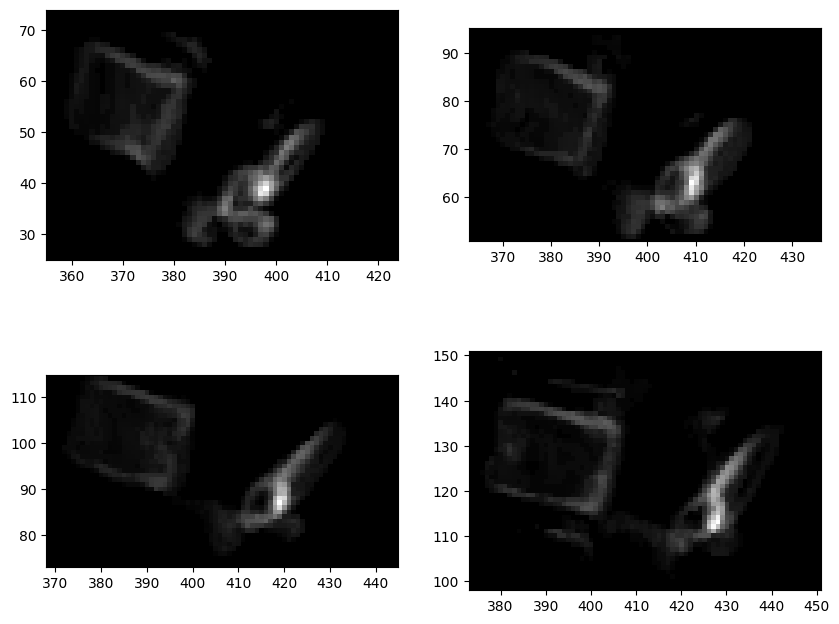

In [9]:
# Plot for individual vertebrae bounding cubes
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax = ax.flatten()

for idx, label in enumerate(vertebrae_labels):
    # Obtain individual vertebra bcube mask
    mask_vertebra = (segment_data == label)
    bcube_vertebra = mask_vertebra*dicom_image
    compressed_bcube_vertebra = compress_bonemri(bcube_vertebra, axis=0)

    # Plot data
    axes_limits = bounding_cubes_coord[label]
    ax[idx].imshow(compressed_bcube_vertebra, cmap="gray")
    ax[idx].set_xlim([axes_limits["x_min"], axes_limits["x_max"]])
    ax[idx].set_ylim([axes_limits["y_min"], axes_limits["y_max"]])